In [1]:
%%time
import sys, os
# import pickle
year = '2023'
path_gen = '/home/eliasmfs/Erasmus MC/Projects/CerebellarLoop'
path_data = f'/mnt/User_Data/UserData/eliasmfs/CerebellarLoop/SlowData/'
path_code = f'{path_gen}/Code/{year}/CerebellarLoop'
path_functions = f'{path_code}/Functions'
sys.path.append(path_data)
sys.path.append(path_functions)

from Run import *
from tqdm import tqdm
from scipy.signal import butter, lfilter, sosfiltfilt, find_peaks
import matplotlib.style as style 
style.use('seaborn-colorblind')



record = {}
record['Noise'] = True
record['PC'] = True
record['DCN'] = True
record['IO'] = True 
record['conn_N_PC'] = True
record['Input_presyn'] = True

save = 1
show = 0

noise_gain_range =  [1]

exp_run = 120000*ms
N_Cells_PC = 100
N_Cells_DCN = 40
N_Cells_IO = 40
N_Cells_PF = 5
plasticity_range = ['no_Plasticity','Plasticity','after_Plasticity']
coupling_range = ['','_Coupled']
zebrin_range = ['negative','positive']

# seed_number_range = []
# for num in range(10):
#     for N_Cells_PF_events in [0]:#0,1,2]:
#         N_Cells_PF_OU = N_Cells_PF - N_Cells_PF_events     
#         if N_Cells_PF_events == 0: 
#             CS_val = 0
#             US_val = 0
#             seed_number_range.append(f'Event_{num}_OU_{N_Cells_PF_OU}_Stim_{N_Cells_PF_events}_CS_{CS_val}_US_{US_val}')
#             continue
#         for CS_val in range(5,10,2):
#             for US_val in range(5,20,5):
#                 seed_number_range.append(f'Event_{num}_OU_{N_Cells_PF_OU}_Stim_{N_Cells_PF_events}_CS_{CS_val}_US_{US_val}')        

                
seed_number_range = []     
for num in [4.2]:#[4.2]:#[4,4.5]:#-2.5,-2,-1.5,-1,2,2.5,3,3.5,4,4.5,5]:
    seed_number_range.append(f'eyeblink_int_{num}')#Paper_all_and_eyeblink')                  

seed_number = seed_number_range[0]

zebrin = zebrin_range[0]
noise_gain = 1

range_plasticity = ['Plasticity']
range_after_plasticity = ['after_Plasticity']

plas_range = 1
if plas_range > 1:
    for plas_num in range(2,plas_range+1):
        plasticity_range.append(f'Plasticity{plas_num}')
        range_plasticity.append(f'Plasticity{plas_num}')
        plasticity_range.append(f'after_Plasticity{plas_num}')
        range_after_plasticity.append(f'after_Plasticity{plas_num}')
        
sims = ["eye_blink"]
        
f0_range = [sims[0]]#,5,10,15,20,25,50,100,800,1000,1100,1200,1300,1400]


parameters_value = { "range_plasticity": range_plasticity, "range_after_plasticity": range_after_plasticity,
                    "PC_I_intrinsic": 0.15, "thresh_M": 60*Hz, "delta_weight_BCM": 0, "delta_weight_CS": -0.1,#-0.02
                    "unfiltered": False, "filtered": True, "f0_range": f0_range, "filter_order": 6, 
                    "simulations": sims,
                    "positive":{
                        "Uncoupled":{'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.2, 'b_OU': -0.7, 
                                     'sigma_OU': 0.7},
                        'Coupled': {'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                    'sigma_OU': 0.7}},
                    'negative':{
                        'Uncoupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                      'sigma_OU': 0.3},
                        'Coupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.6, 
                                    'sigma_OU': 0.7}}}


Params, Noise_frozen, Values, Synaps, net_name = frozen_tun(seed_number_range,N_Cells_PC,N_Cells_DCN,N_Cells_IO,path_data,exp_run)
IO_num_con = Synaps['Seed_'+str(seed_number)].IO_PC_Synapse_Sources

dt = Params['Seed_'+str(seed_number)].dt
dt_rec = float(Params['Seed_'+str(seed_number)].dt_rec)
time_x = [x * dt for x in range(0,int(exp_run/dt))]
time_x_rec = [x * dt for x in range(0,int(exp_run/dt_rec))]


coupling = '_Coupled'
plasticity = 'no_Plasticity'
f0 = f0_range[0]

WARNING    <timed exec>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
 [py.warnings]



CPU times: user 30.7 s, sys: 10.2 s, total: 40.9 s
Wall time: 56 s


# Figure S6-2 - A

100%|██████████| 9/9 [00:00<00:00, 171.80it/s]


CPU times: user 2.48 s, sys: 14.8 s, total: 17.3 s
Wall time: 1min 50s


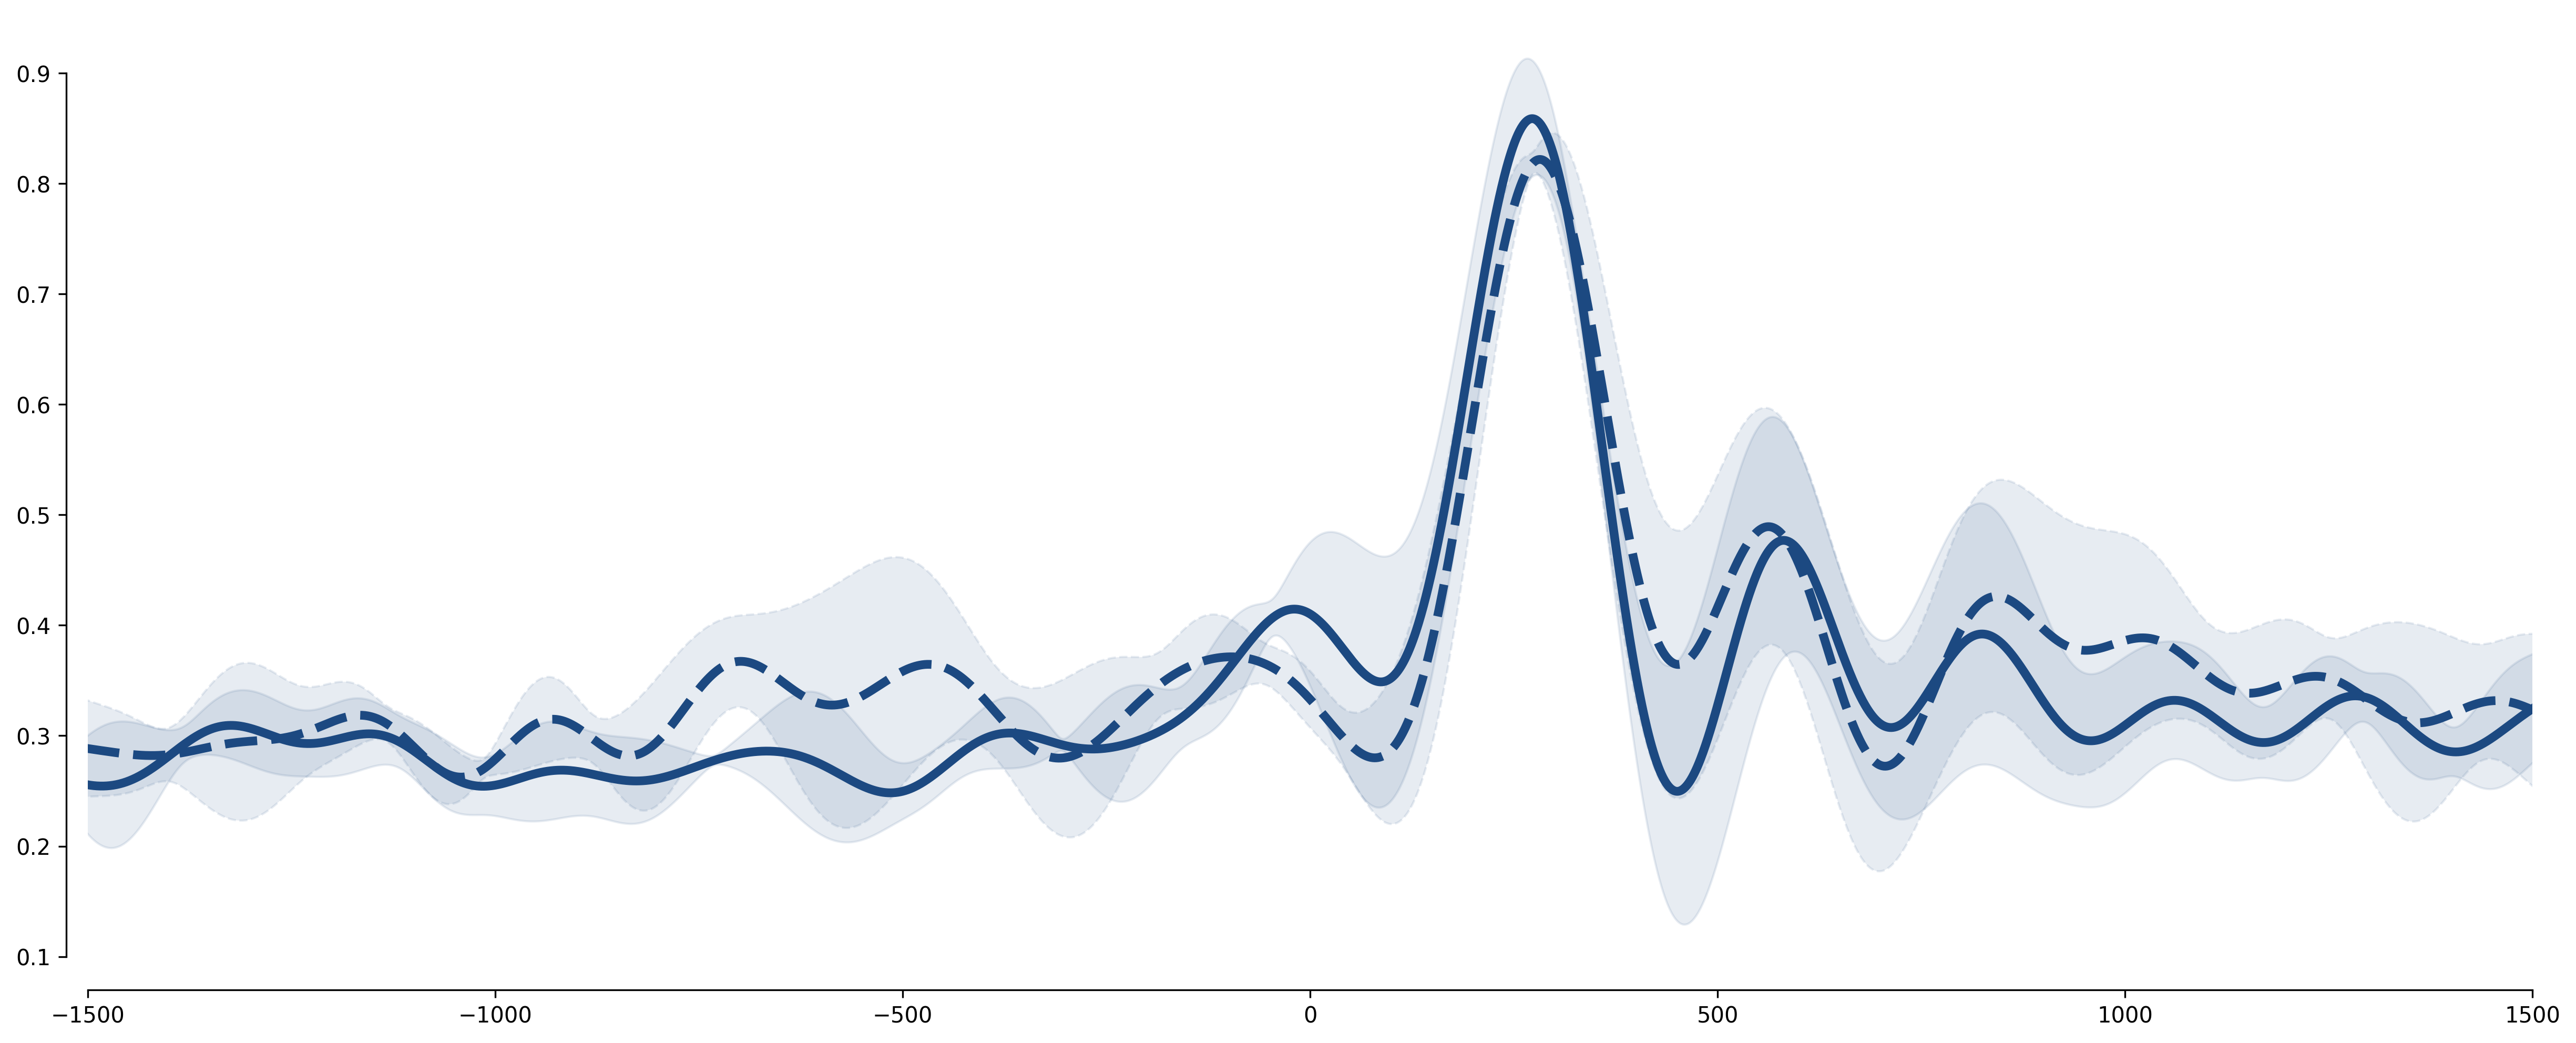

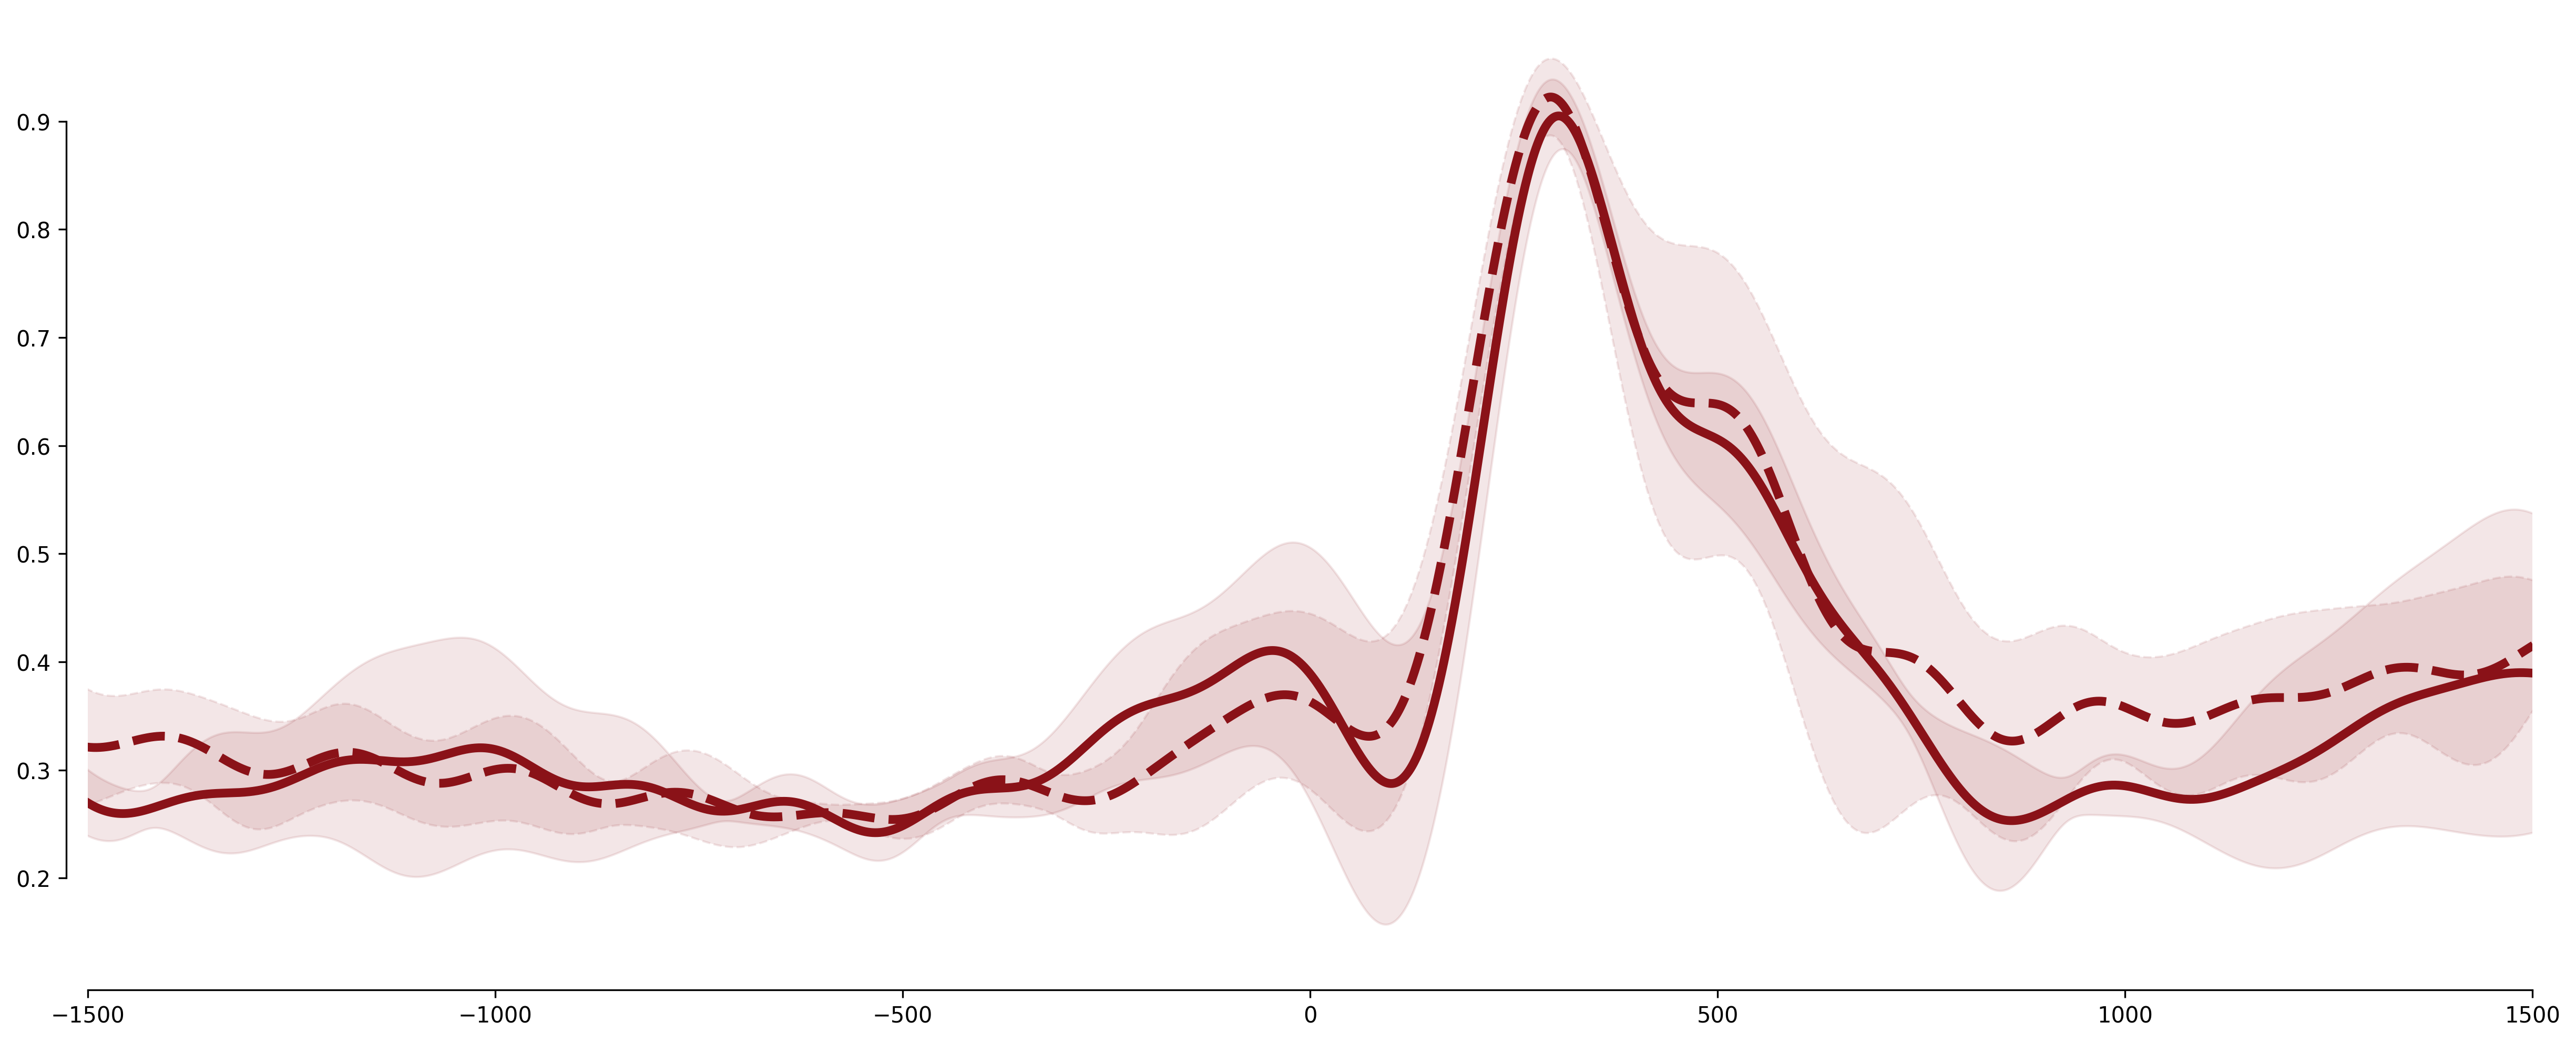

In [2]:
%%time
import collections
import scipy.signal
import tqdm
import functools
from IPython.display import HTML, display

@functools.lru_cache
def load_io_vs(coupling=True, plasticity=True, zebrin=True, n=0, f0=f0, noise_gain=1):
    if plasticity is None:
        p = 'Plasticity'
    elif plasticity:
        p = 'after_Plasticity'
    else:
        p = 'no_Plasticity'
    if n > 1:
        p = f'{p}{n}'
    IO_output = output_load_run('IO',
                                '_Coupled' if coupling else '',seed_number,
                                p,['negative', 'positive'][zebrin],noise_gain,exp_run,net_name,path_data,parameters_value,f0)
    return np.array(IO_output['Vs']/mV)



@functools.lru_cache
def load_io_spikes(coupling=True, plasticity=True, zebrin=True, n=0, f0=f0, noise_gain=1):
    if plasticity is None:
        p = 'Plasticity'
    elif plasticity:
        p = 'after_Plasticity'
    else:
        p = 'no_Plasticity'
    if n > 1:
        p = f'{p}{n}'
    o = output_load_run('IO_spikes','_Coupled' if coupling else '',seed_number,
                           p,['negative', 'positive'][zebrin],noise_gain,exp_run,net_name,path_data,parameters_value,f0)

    x = []
    for i in range(N_Cells_IO):
        x.append(o[str(i)])
    return x

@functools.lru_cache
def load_pc_psc(coupling=True, plasticity=True, zebrin=True, n=0, f0=f0, noise_gain=1):
    if plasticity is None:
        p = 'Plasticity'
    elif plasticity:
        p = 'after_Plasticity'
    else:
        p = 'no_Plasticity'
    if n > 1:
        p = f'{p}{n}'
    o = output_load_run('PC',
                                '_Coupled' if coupling else '',seed_number,
                                p,['negative', 'positive'][zebrin],noise_gain,exp_run,net_name,path_data,parameters_value,f0)
    return np.array(o['I_Noise']/nA*amp)



class Case(collections.abc.Mapping):
    def __init__(self, **kw):
        self.kw = kw
        for k in kw:
            assert k in ['coupling', 'zebrin', 'plasticity']
    def __len__(self):
        return 1
    def __getitem__(self, k):
        return self.kw[k]
    def __iter__(self):
        return iter(self.kw)
    def __eq__(self, other):
        for k in ['coupling', 'zebrin', 'plasticity']:
            if self.kw.get(k, '*') !=  other.kw.get(k, '*'):
                return False
        return True
    def __hash__(self):
        return __builtins__.sum(hash(f'{k}{self.kw.get(k, "*")}') for k in ['coupling', 'zebrin', 'plasticity'])
    @property
    def before(self):
        kw = dict(self.kw)
        kw['plasticity'] = False
        return Case(**kw)
    @property
    def after(self):
        kw = dict(self.kw)
        kw['plasticity'] = True
        return Case(**kw)
    @property
    def during(self):
        kw = dict(self.kw)
        kw['plasticity'] = None
        return Case(**kw)
    def __repr__(self):
        return '/'.join([
            {True: 'C', False: 'U', '*': '*'}[self.kw.get('coupling', '*')],
            {True: 'Z+', False: 'Z-', '*': '*'}[self.kw.get('zebrin', '*')],
            {True: 'AP', False: 'NP', None: 'P', '*': '*'}[self.kw.get('plasticity', '*')]])
    
import tqdm
def stvmsync(ev, vm, transient_ms=10000, window_ms=500, skip=1, **k):
    windows = []
    for s1 in tqdm.tqdm(ev * 1000):
        if np.random.random() > skip: continue
        if s1 - window_ms < transient_ms or s1 + window_ms > 60000: continue
        v = vm[:,int(round(s1 - window_ms)):int(round(s1 + window_ms))]
        if v.shape[1] != window_ms*2: continue
        kp = calc_synchrony(v, lp=4, lpsync=4)
        windows.append(kp)
    w = np.stack(windows)
    x = np.arange(-window_ms, +window_ms)
    return x, w

def calc_synchrony(vs, fs=1000, order=5, lp=8, hp=15, lpsync=5):
    'Ncells x Ntimesteps -> Ntimesteps'
    # synchrony changing faster than 5Hz doens't make sense for 10Hz STO's
    sos = scipy.signal.butter(order, (lp, hp), 'bp', fs=fs, output='sos')
    filt = scipy.signal.sosfiltfilt(sos, vs)
    analytic = scipy.signal.hilbert(filt - filt.mean())
    angle = np.exp(1j*np.angle(analytic))
    synchrony = abs(angle.mean(0))
    sos = scipy.signal.butter(order, lpsync, 'lp', fs=fs, output='sos')
    return scipy.signal.sosfiltfilt(sos, synchrony)

seed_number = seed_number_range[0]

f0_range = ['eye_blink']

Noise_sim = Noise_frozen[f'Seed_{seed_number}'].Noise_sim
iti_arr = Noise_sim['iti_arr_eye_blink']
# iti_arr = [10*second]*len(iti_arr)
iti_arr = iti_arr*second
iti_arr

CS_dur = 220*ms
US_dur = 30*ms
transient = iti_arr[0]
ini_US_onset = transient
ini_US_ofset = transient+US_dur
CS_onset = [ini_US_ofset+iti_arr[1]]
US_onset = [CS_onset[0]+CS_dur]
CS_ofset = [CS_onset[0]+CS_dur+US_dur]
US_ofset = [US_onset[0]+US_dur]

for idx,iti in enumerate(iti_arr[2:-1]):
    CS_onset.append(CS_ofset[idx]+iti)
    US_onset.append(US_ofset[idx]+iti+CS_dur)
    CS_ofset.append(CS_ofset[idx]+iti+CS_dur+US_dur)
    US_ofset.append(US_ofset[idx]+iti+CS_dur+US_dur)

CS_onset = np.array(CS_onset)
US_onset = np.array(US_onset)
CS_ofset = np.array(CS_ofset)
US_ofset = np.array(US_ofset)

F0 = 'eye_blink'

        

CP = Case(coupling=True, zebrin=True)
CN = Case(coupling=True, zebrin=False)
UP = Case(coupling=False, zebrin=True)
UN = Case(coupling=False, zebrin=False)

cases = [CP, CN, UP, UN]


PC = 'pc'
DCN = 'dcn'
IO = 'io'

cells = [PC, DCN, IO]

spikes = {}
for case in cases:
    spikes[IO,   case.before] = load_io_spikes(**case.before)
    spikes[IO,   case.after]  = load_io_spikes(**case.after)
    
vm = {}
for case in cases:
    vm[IO,   case.before] = load_io_vs(**case.before)
    vm[IO,   case.after]  = load_io_vs(**case.after)
    vm[IO,   case.during]  = load_io_vs(**case.after)
    
psc = {}
for case in cases:
    psc[PC,   case.before] = load_pc_psc(**case.before)
    psc[PC,   case.after]  = load_pc_psc(**case.after)
    


pre = CS_onset



fig = plt.figure(figsize=(20, 8),dpi=300)
# fig.suptitle(f'Conditional Stimulus triggered IO synchrony')
cases2 = [CP.before, CN.before, CN.after, CP.after]

colors = dict(positive='#1c4981',negative='#8a1218')
case = UP.before
t, kp = stvmsync(pre, vm[IO, case], window_ms=2000)
plot(t, kp.mean(0), color='#1c4981',lw=4)
fill_between(t, kp.mean(0)-kp.std(0), kp.mean(0)+kp.std(0), alpha=0.1, color='#1c4981')
xlim([-1500, 1500])

case = UP.after
t, kp = stvmsync(pre, vm[IO, case], window_ms=2000)
plot(t, kp.mean(0), ls='--', color='#1c4981',lw=4)
fill_between(t, kp.mean(0)-kp.std(0), kp.mean(0)+kp.std(0), alpha=0.1, color='#1c4981', ls='--')
xlim([-1500, 1500])
sns.despine(trim=True,offset=10)
plt.savefig(f'{coupling} kura_pos.svg')
fig = plt.figure(figsize=(20, 8),dpi=300)
# fig.suptitle(f'Conditional Stimulus triggered IO synchrony')
case = UN.before
t, kp = stvmsync(pre, vm[IO, case], window_ms=2000)
plot(t, kp.mean(0), color='#8a1218',lw=4)
fill_between(t, kp.mean(0)-kp.std(0), kp.mean(0)+kp.std(0), alpha=0.1, color='#8a1218')
xlim([-1500, 1500])

case = UN.after
t, kp = stvmsync(pre, vm[IO, case], window_ms=2000)
plot(t, kp.mean(0), ls='--', color='#8a1218',lw=4)
fill_between(t, kp.mean(0)-kp.std(0), kp.mean(0)+kp.std(0), alpha=0.1, color='#8a1218', ls='--')
xlim([-1500, 1500])
sns.despine(trim=True,offset=10)
plt.savefig(f'{coupling} kura_neg.svg')

# left.set_ylabel('Kuramoto phase ([0-1])')
# left.set_xlabel('Time since CS onset (ms)')
# right.set_xlabel('Time since CS onset (ms)')

# left.set_ylim([0,1])

# Figure S6 - B

#### SSpks

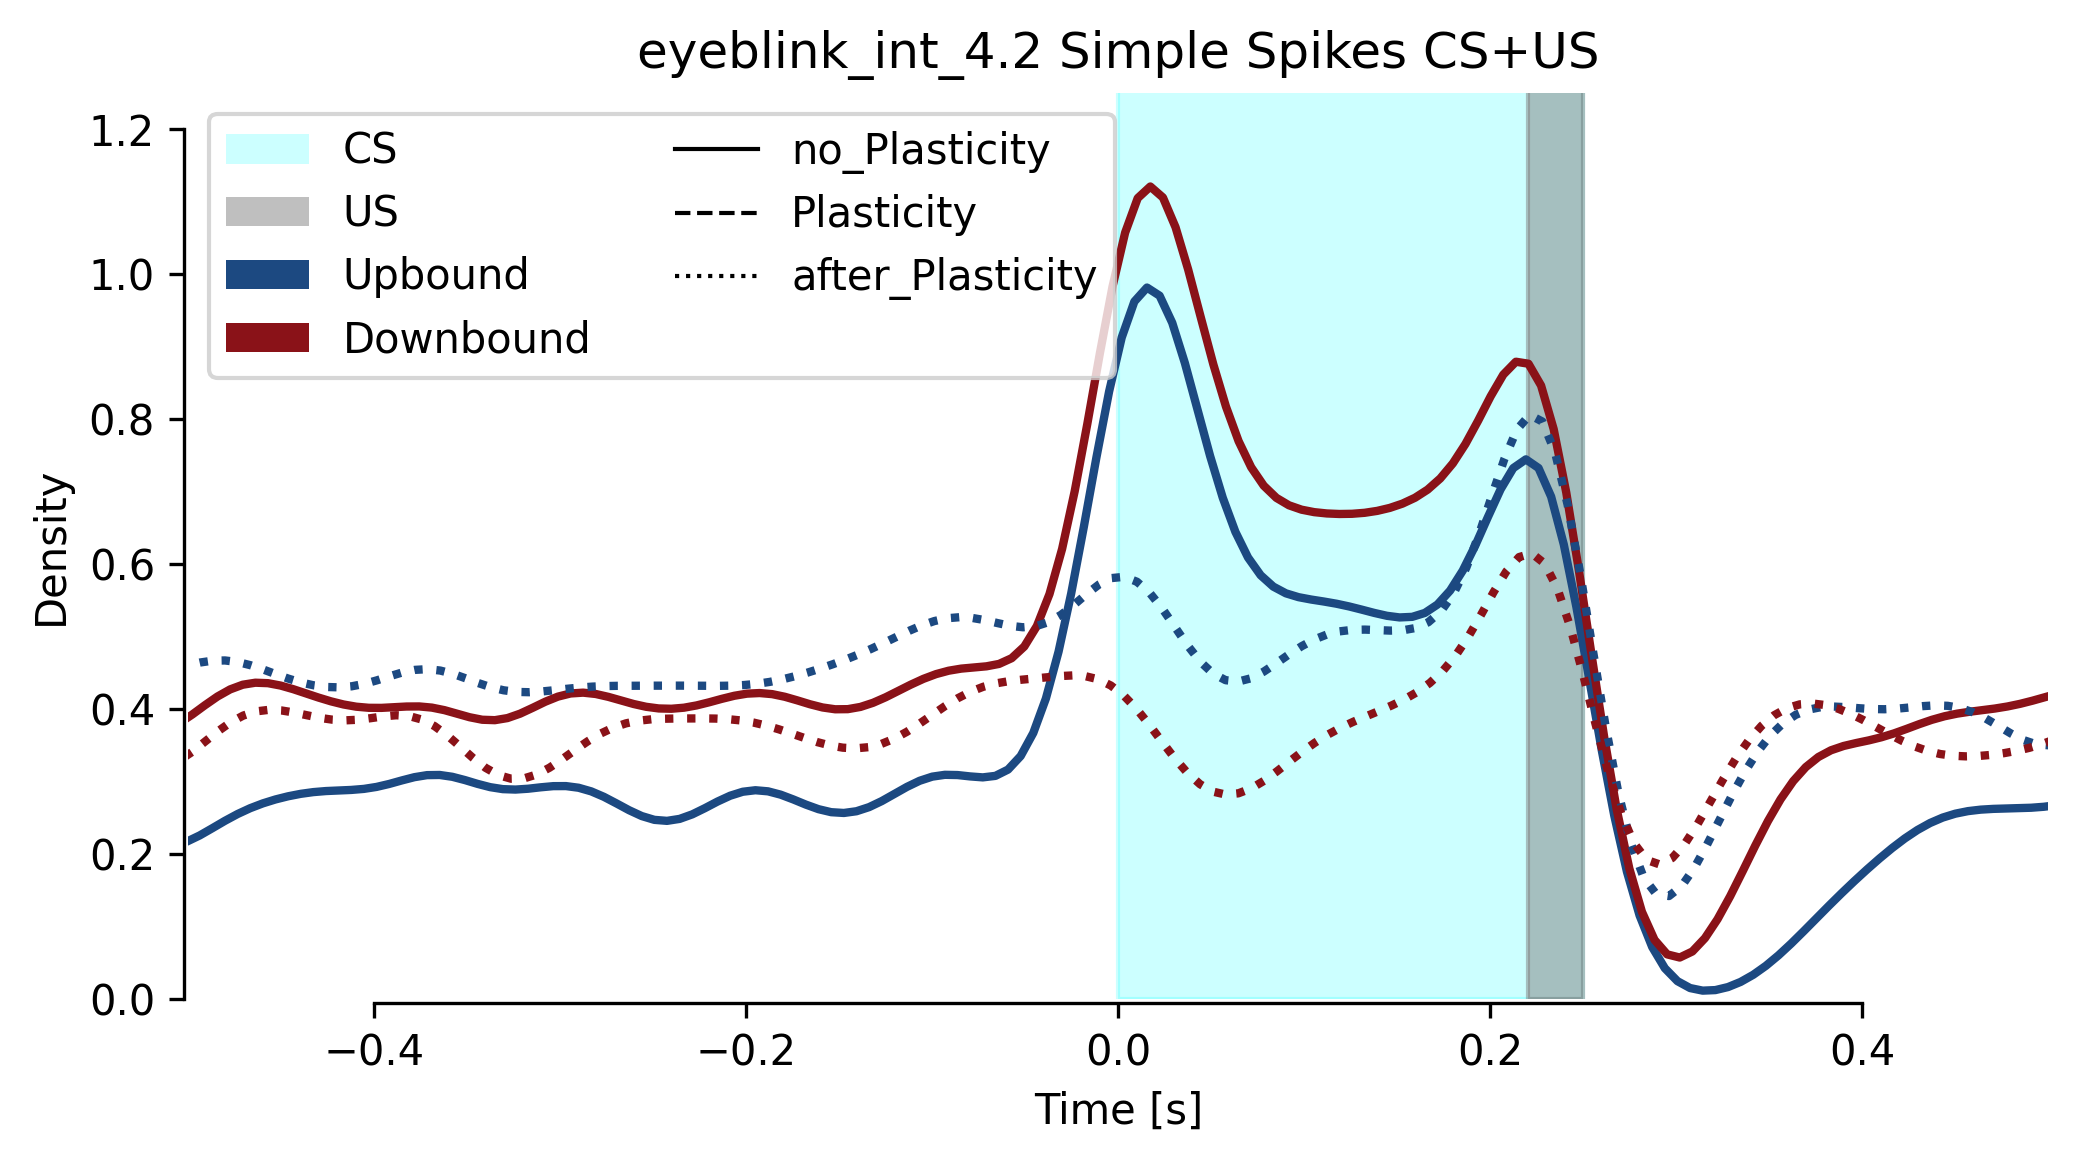

CPU times: user 2.23 s, sys: 9.48 s, total: 11.7 s
Wall time: 1min 12s


In [3]:
%%time
data=[]
plas_rang = ['no_Plasticity']
plas_rang.extend(range_after_plasticity)
step = 0.6
f0_range = [f0]


for seed_number in seed_number_range:
    Noise_sim = Noise_frozen[f'Seed_{seed_number}'].Noise_sim
    iti_arr = Noise_sim['iti_arr_eye_blink']
    # iti_arr = [10*second]*len(iti_arr)
    iti_arr = iti_arr*second
    iti_arr

    CS_dur = 220*ms
    US_dur = 30*ms
    transient = iti_arr[0]
    ini_US_onset = transient
    ini_US_ofset = transient+US_dur
    CS_onset = [ini_US_ofset+iti_arr[1]]
    US_onset = [CS_onset[0]+CS_dur]
    CS_ofset = [CS_onset[0]+CS_dur+US_dur]
    US_ofset = [US_onset[0]+US_dur]

    for idx,iti in enumerate(iti_arr[2:-1]):
        CS_onset.append(CS_ofset[idx]+iti)
        US_onset.append(US_ofset[idx]+iti+CS_dur)
        CS_ofset.append(CS_ofset[idx]+iti+CS_dur+US_dur)
        US_ofset.append(US_ofset[idx]+iti+CS_dur+US_dur)

    fin_CS_onset = CS_ofset[-1]+iti_arr[-1]
    fin_CS_ofset = fin_CS_onset+CS_dur+US_dur
    for f0 in f0_range[0:1]:
        for zebrin in ['negative','positive']:
            for plasticity in ['no_Plasticity','after_Plasticity']:
                for coupling in ['_Coupled','']:
                    PC_output = output_load_run('PC',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                    PC_spikes = output_load_run('PC_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                    for PC_num in range(1):#N_Cells_PC):
                        for stim_time in CS_onset:
                            stim_time=stim_time/second
                            start = int(stim_time*second/dt_rec)-int(step*second/dt_rec)
                            end = int(stim_time*second/dt_rec)+int(step*second/dt_rec)
                            if stim_time < step: continue
                            if stim_time+step > exp_run/second: continue
                            IO_trig_avg = PC_output['v'][PC_num][start:end]/mV*volt
                            for io_spike in PC_spikes[f'{PC_num}']:
                                if start < io_spike/dt_rec < end:
                                    spike_time = io_spike
                                    corr_spike_time = spike_time - stim_time
                                    row=dict(seed_number=seed_number,cell=PC_num,stimtime=stim_time,spiketime=spike_time,corr_spiketime=corr_spike_time,f0=f0,zebrin=zebrin,plasticity=plasticity,coupling=coupling,IO_trig_avg=IO_trig_avg)
                                    data.append(row)
df_all_PC_onset = pd.DataFrame(data) 


from matplotlib.lines import Line2D
from matplotlib.patches import Patch
coupling = ''
ls_p=dict(no_Plasticity='-',Plasticity='--',after_Plasticity=':')
for seed_number in seed_number_range:
    figure(figsize=(8, 4),dpi=300)
    title(f'{seed_number} Simple Spikes CS+US')
    for plasticity in ['no_Plasticity','after_Plasticity']:
        df_hist = df_all_PC_onset[(df_all_PC_onset['seed_number']==seed_number)&(df_all_PC_onset['plasticity']==plasticity)&(df_all_PC_onset['f0']==f0)&(df_all_PC_onset['coupling']==coupling)]
        aa = sns.kdeplot(data=df_hist, x="corr_spiketime", hue='zebrin',bw_adjust=.3,lw=2,linestyle=ls_p[plasticity],palette={"negative": "#8a1218", "positive": "#1c4981"})#, "after_Plasticity": "r"})
    aa.legend_.remove()
    fill_between([0, 0.25],[0,0],[2,2], color='cyan', alpha=0.2)
    fill_between([0.22, 0.25],[0,0],[2,2], color='grey', alpha=0.5)
    xlim(-0.5,0.5)
    ylim(0,1.25)
    xlabel('Time [s]')
    sns.despine(trim=True,offset=True)

    legend_elements = [Patch(facecolor='cyan', alpha=0.2, label='CS'),
                       Patch(facecolor='grey', alpha=0.5, label='US'),
                       Patch(facecolor='#1c4981', label='Upbound'),
                       Patch(facecolor='#8a1218', label='Downbound'),
                       Line2D([0], [0], linestyle='-', color='k', lw=1, label='no_Plasticity'),
                       Line2D([0], [0], linestyle='--', color='k', lw=1, label='Plasticity'),
                       Line2D([0], [0], linestyle=':', color='k', lw=1, label='after_Plasticity')]
    legend(handles=legend_elements, loc='upper left',ncol=2)
    plt.savefig(f'{seed_number} {coupling} SS Spikes CS+US.svg')
    plt.show()


#### CSpks

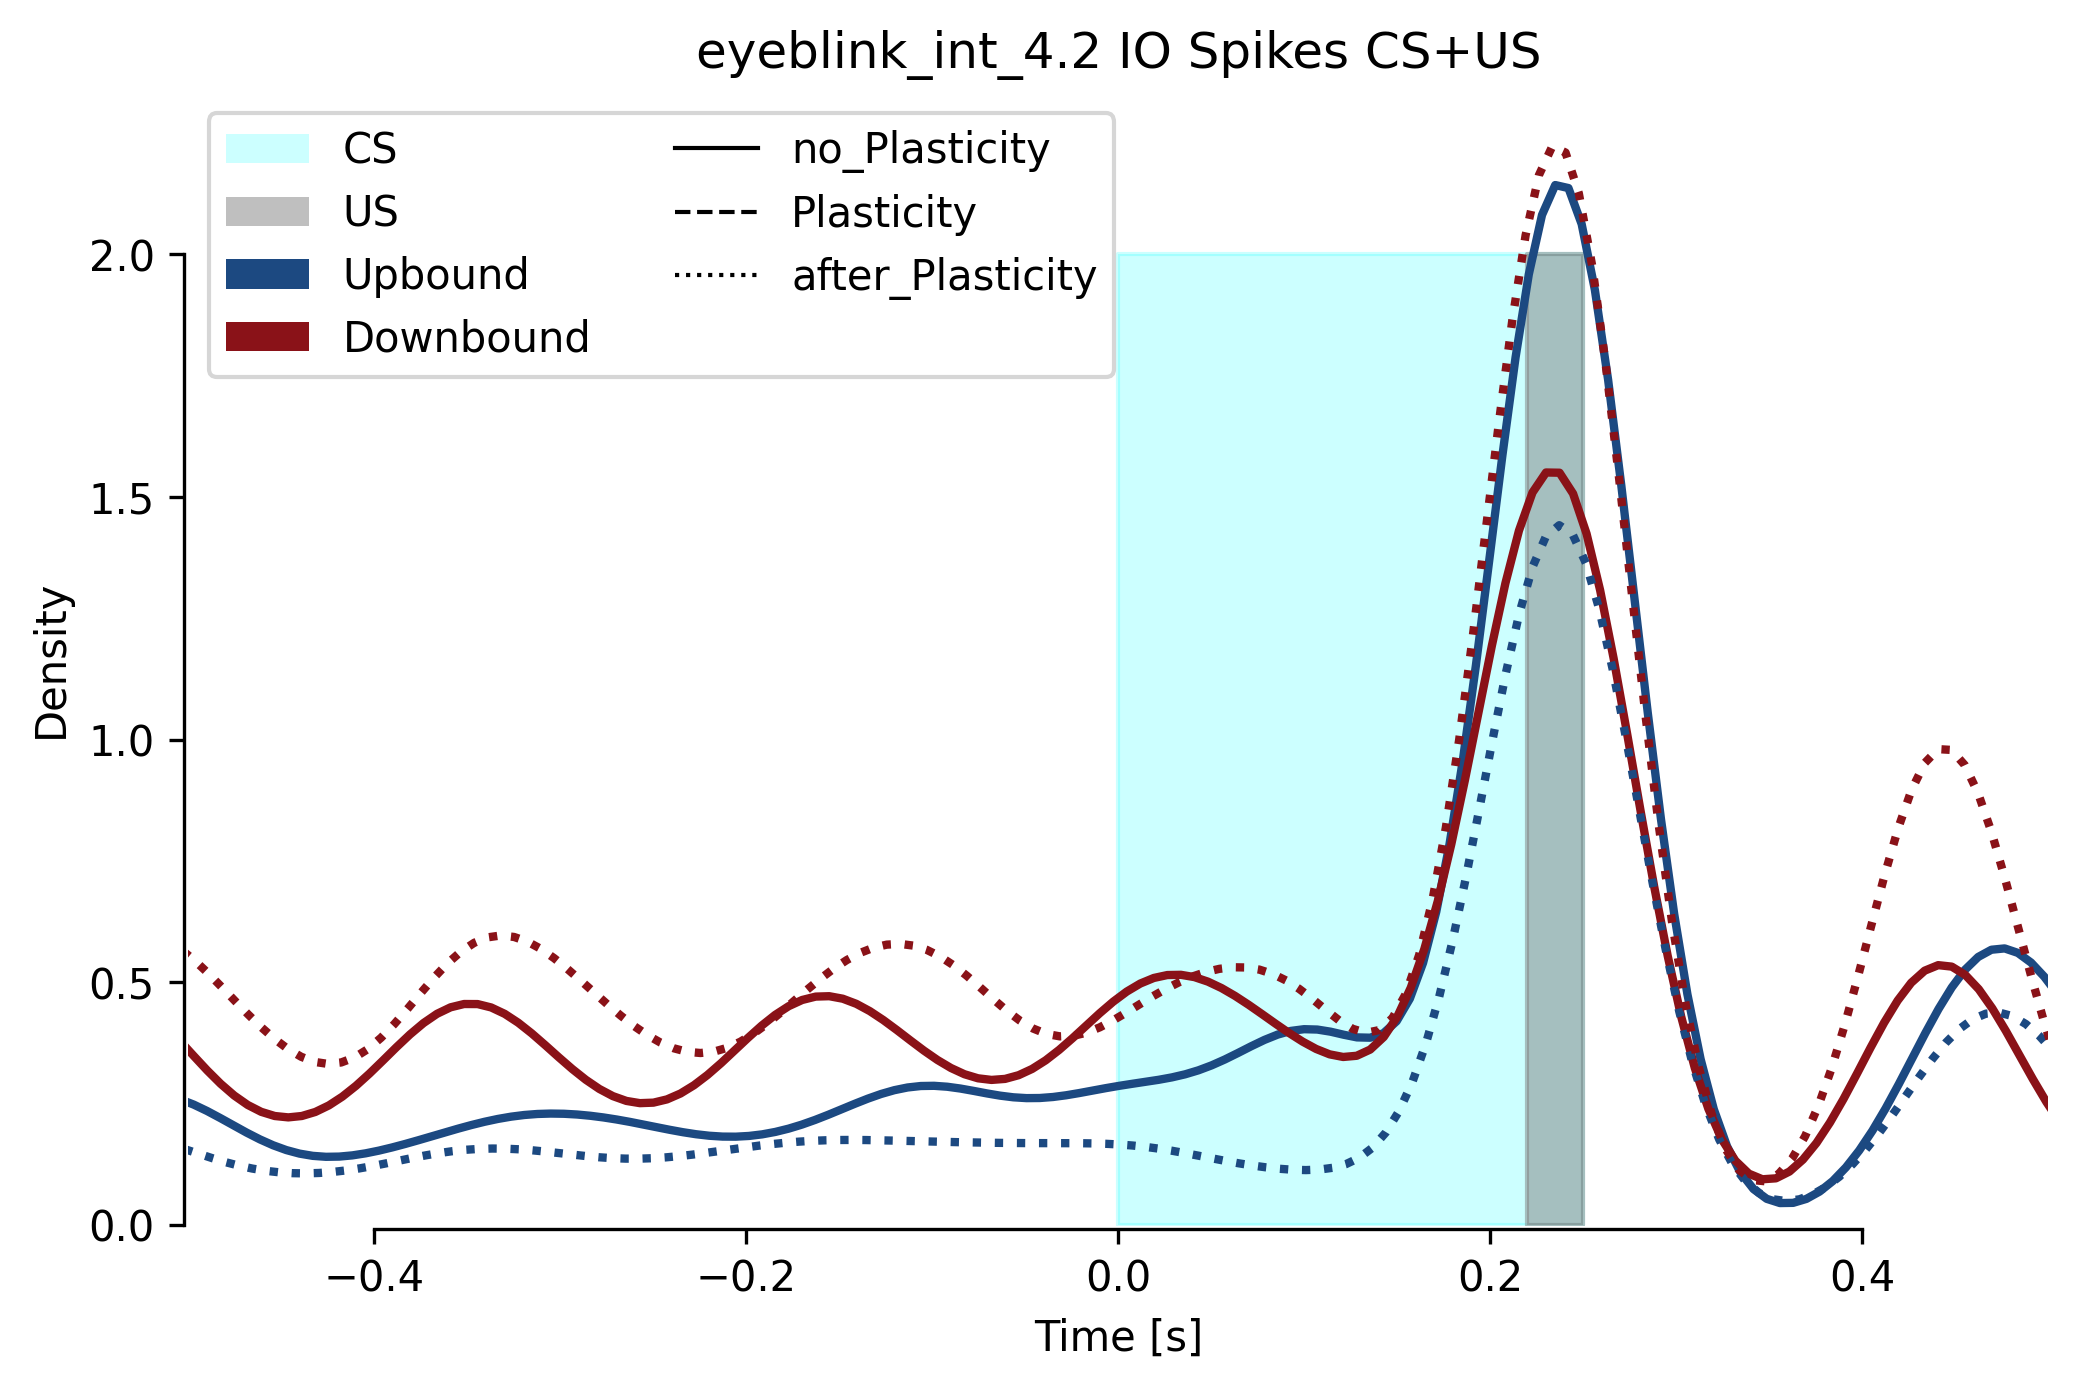

CPU times: user 2.34 s, sys: 6.94 s, total: 9.27 s
Wall time: 33.3 s


In [4]:
%%time
data=[]
plas_rang = ['no_Plasticity']
plas_rang.extend(range_after_plasticity)
step = 0.6
f0_range = [f0]


for seed_number in seed_number_range:
    Noise_sim = Noise_frozen[f'Seed_{seed_number}'].Noise_sim
    iti_arr = Noise_sim['iti_arr_eye_blink']
    # iti_arr = [10*second]*len(iti_arr)
    iti_arr = iti_arr*second
    iti_arr

    CS_dur = 220*ms
    US_dur = 30*ms
    transient = iti_arr[0]
    ini_US_onset = transient
    ini_US_ofset = transient+US_dur
    CS_onset = [ini_US_ofset+iti_arr[1]]
    US_onset = [CS_onset[0]+CS_dur]
    CS_ofset = [CS_onset[0]+CS_dur+US_dur]
    US_ofset = [US_onset[0]+US_dur]

    for idx,iti in enumerate(iti_arr[2:-1]):
        CS_onset.append(CS_ofset[idx]+iti)
        US_onset.append(US_ofset[idx]+iti+CS_dur)
        CS_ofset.append(CS_ofset[idx]+iti+CS_dur+US_dur)
        US_ofset.append(US_ofset[idx]+iti+CS_dur+US_dur)

    fin_CS_onset = CS_ofset[-1]+iti_arr[-1]
    fin_CS_ofset = fin_CS_onset+CS_dur+US_dur
    for f0 in f0_range[0:1]:
        for zebrin in ['negative','positive']:
            for plasticity in plasticity_range:#['no_Plasticity','after_Plasticity']:
                for coupling in ['_Coupled','']:
                    IO_output = output_load_run('IO',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                    IO_spikes = output_load_run('IO_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                    for io_num in range(N_Cells_IO):
                        for stim_time in CS_onset:
                            stim_time=stim_time/second
                            start = int(stim_time*second/dt_rec)-int(step*second/dt_rec)
                            end = int(stim_time*second/dt_rec)+int(step*second/dt_rec)
                            if stim_time < step: continue
                            if stim_time+step > exp_run/second: continue
                            IO_trig_avg = IO_output['Vs'][io_num][start:end]/mV*volt
                            for io_spike in IO_spikes[f'{io_num}']:
                                if start < io_spike/dt_rec < end:
                                    spike_time = io_spike
                                    corr_spike_time = spike_time - stim_time
                                    row=dict(seed_number=seed_number,cell=io_num,stimtime=stim_time,spiketime=spike_time,corr_spiketime=corr_spike_time,f0=f0,zebrin=zebrin,plasticity=plasticity,coupling=coupling,IO_trig_avg=IO_trig_avg)
                                    data.append(row)
df_all_IO_onset = pd.DataFrame(data) 

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
coupling = ''
ls_p=dict(no_Plasticity='-',Plasticity='--',after_Plasticity=':')
for seed_number in seed_number_range:
    figure(figsize=(8, 5),dpi=300)
    title(f'{seed_number} IO Spikes CS+US')
    for plasticity in ['no_Plasticity','after_Plasticity']:
        df_hist = df_all_IO_onset[(df_all_IO_onset['seed_number']==seed_number)&(df_all_IO_onset['plasticity']==plasticity)&(df_all_IO_onset['f0']==f0)&(df_all_IO_onset['coupling']==coupling)] 
        aa = sns.kdeplot(data=df_hist, x="corr_spiketime", hue='zebrin',bw_adjust=.5,lw=2,linestyle=ls_p[plasticity],palette={"negative": "#8a1218", "positive": "#1c4981"})#, "after_Plasticity": "r"})
    aa.legend_.remove()
    fill_between([0, 0.25],[0,0],[2,2], color='cyan', alpha=0.2)
    fill_between([0.22, 0.25],[0,0],[2,2], color='grey', alpha=0.5)
    xlim(-0.5,0.5)
#     ylim(0,1)
    xlabel('Time [s]')
    sns.despine(trim=True,offset=True)
  
    legend_elements = [Patch(facecolor='cyan', alpha=0.2, label='CS'),
                       Patch(facecolor='grey', alpha=0.5, label='US'),
                       Patch(facecolor='#1c4981', label='Upbound'),
                       Patch(facecolor='#8a1218', label='Downbound'),
                       Line2D([0], [0], linestyle='-', color='k', lw=1, label='no_Plasticity'),
                       Line2D([0], [0], linestyle='--', color='k', lw=1, label='Plasticity'),
                       Line2D([0], [0], linestyle=':', color='k', lw=1, label='after_Plasticity')]
    legend(handles=legend_elements, loc='upper left',ncol=2)
    plt.savefig(f'{seed_number} {coupling} IO Spikes CS+US.svg')
    plt.show()


# Figure S6-2 - C,D

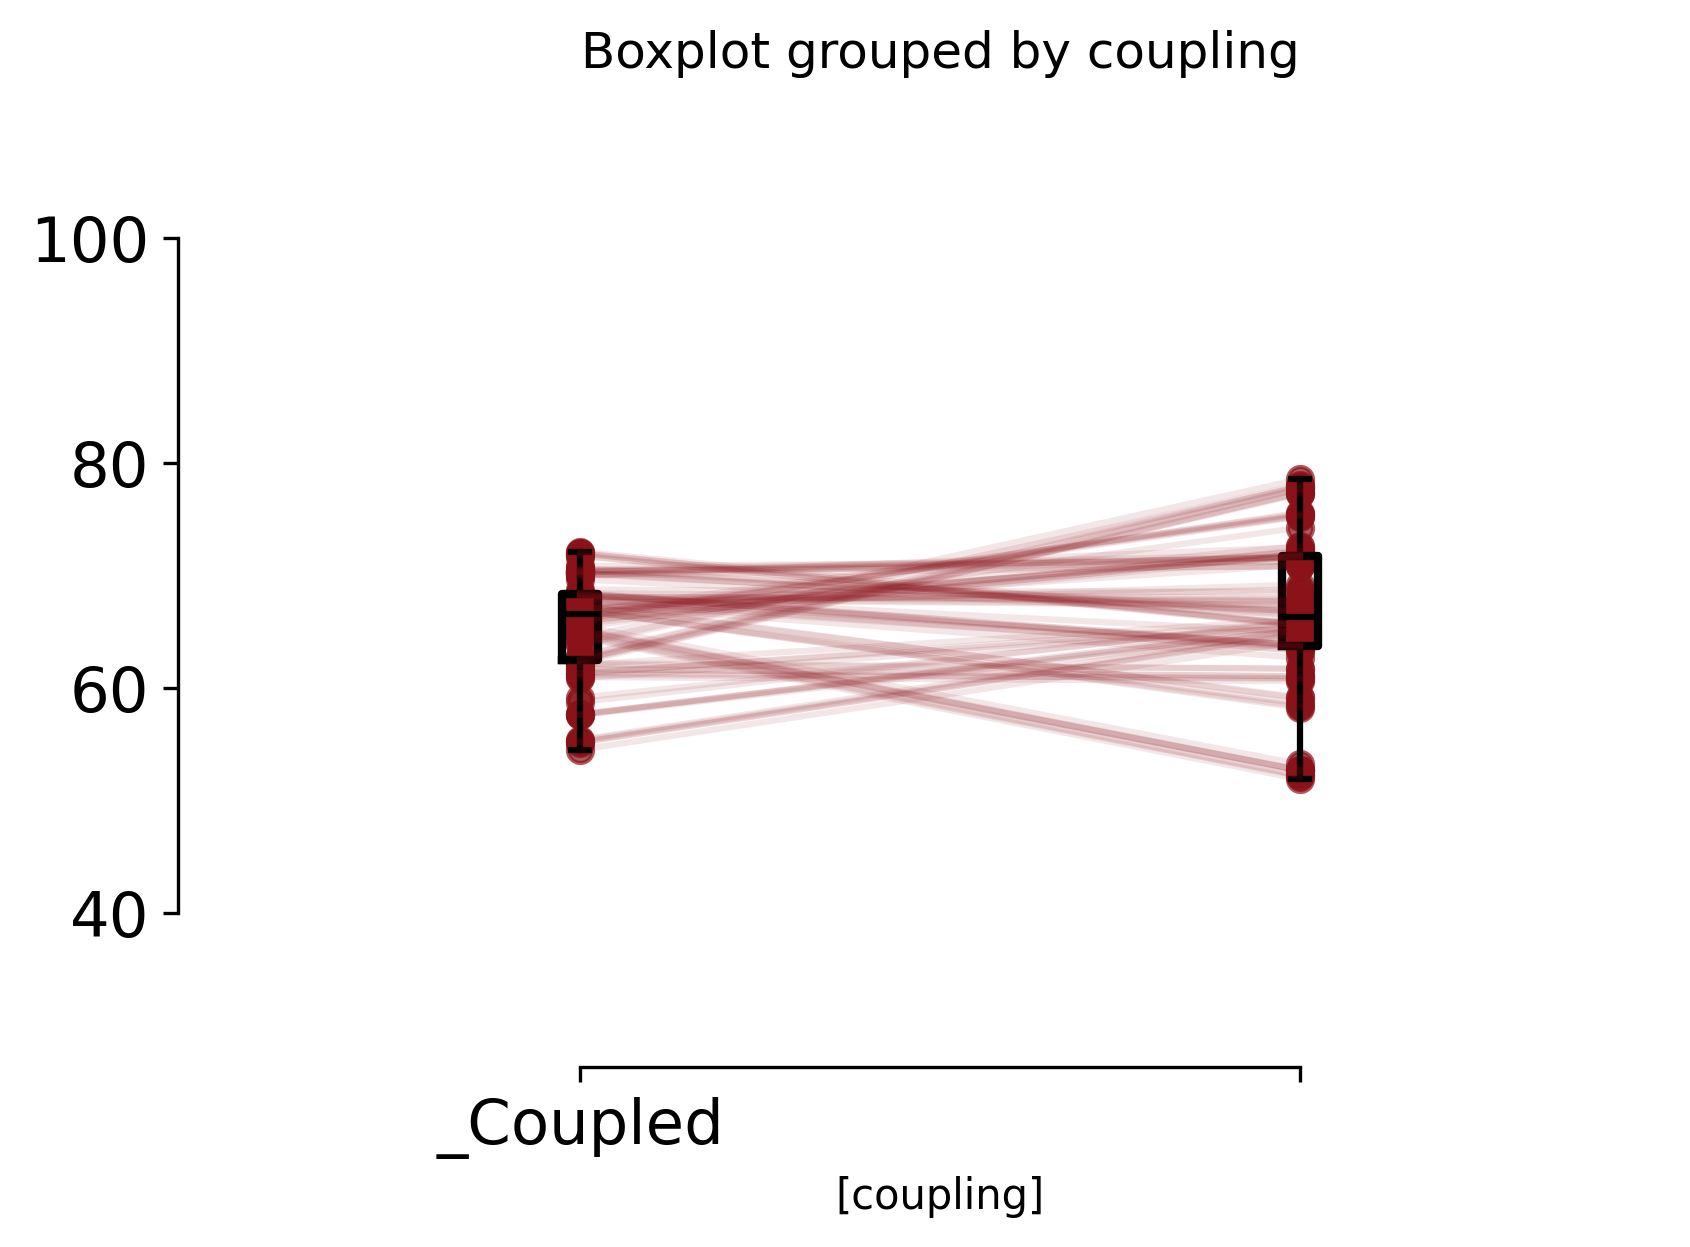

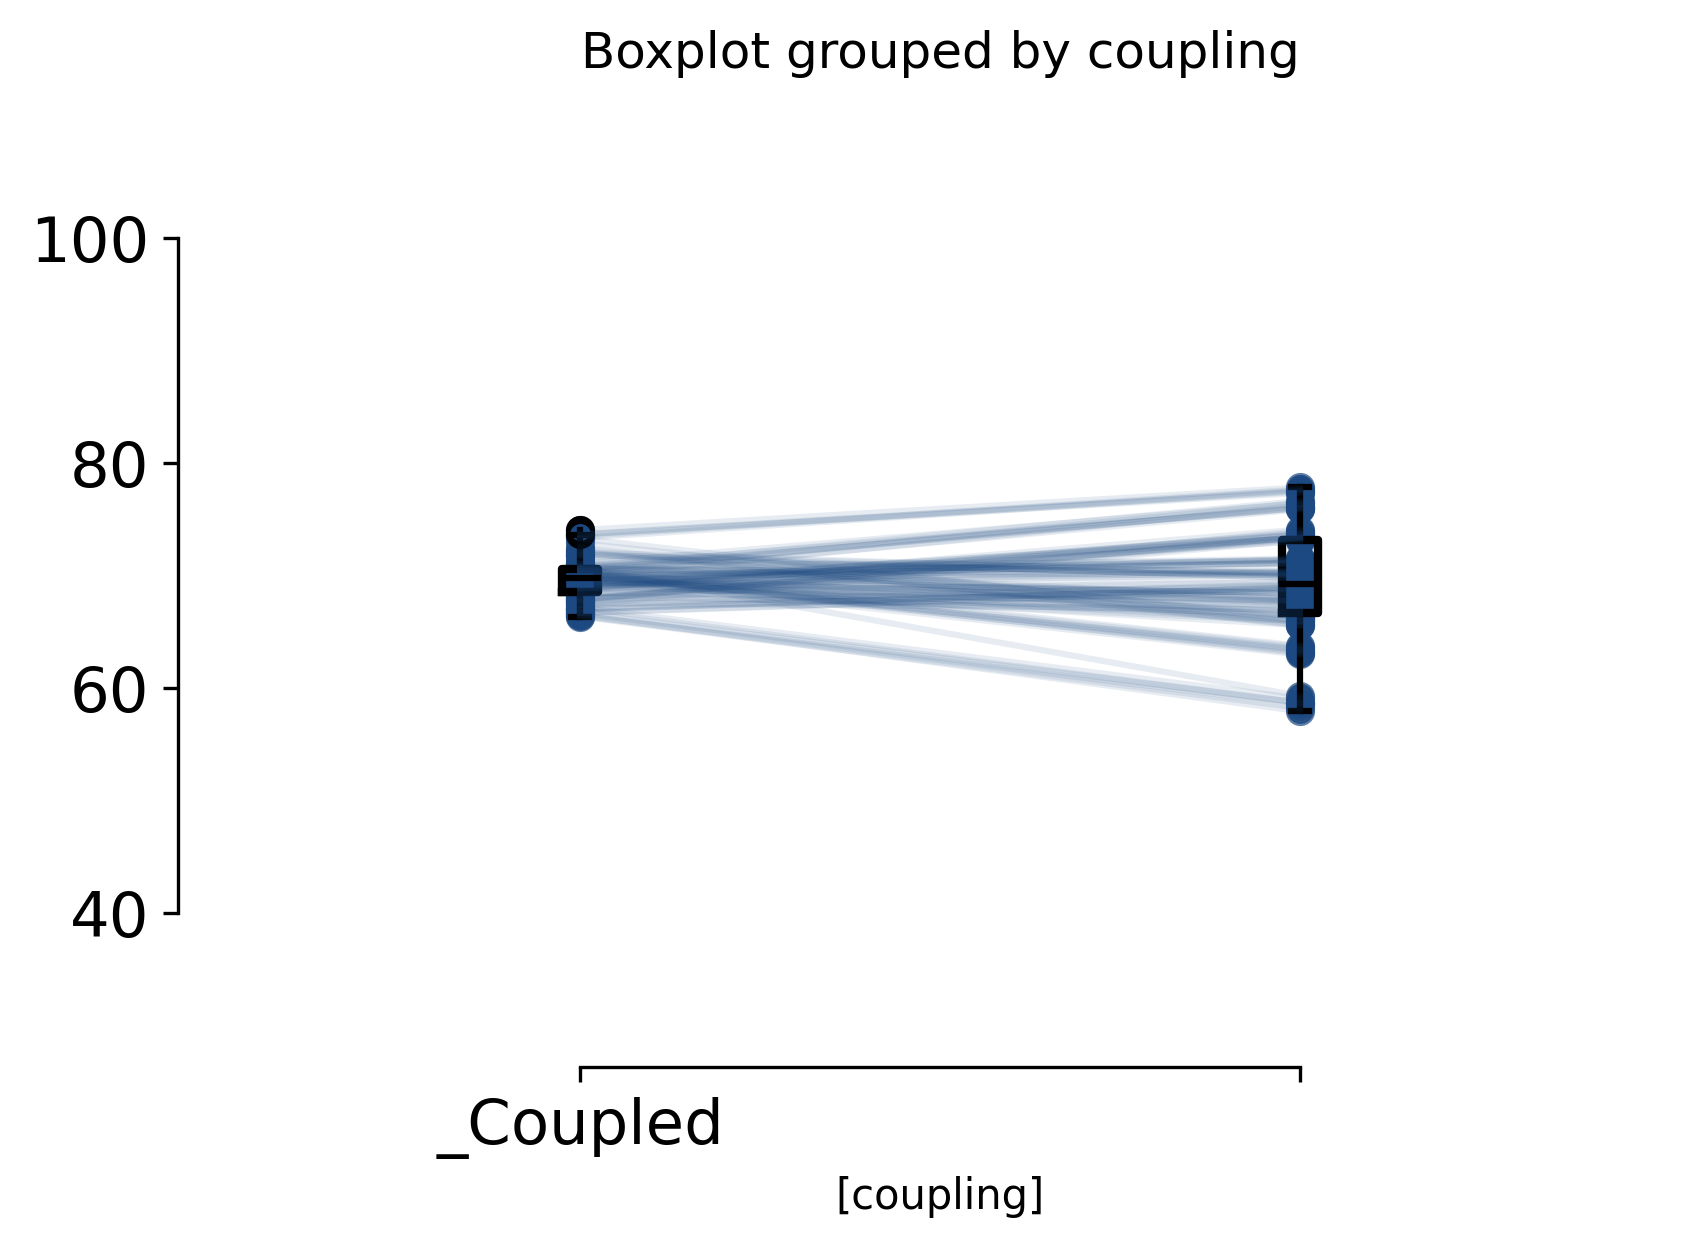

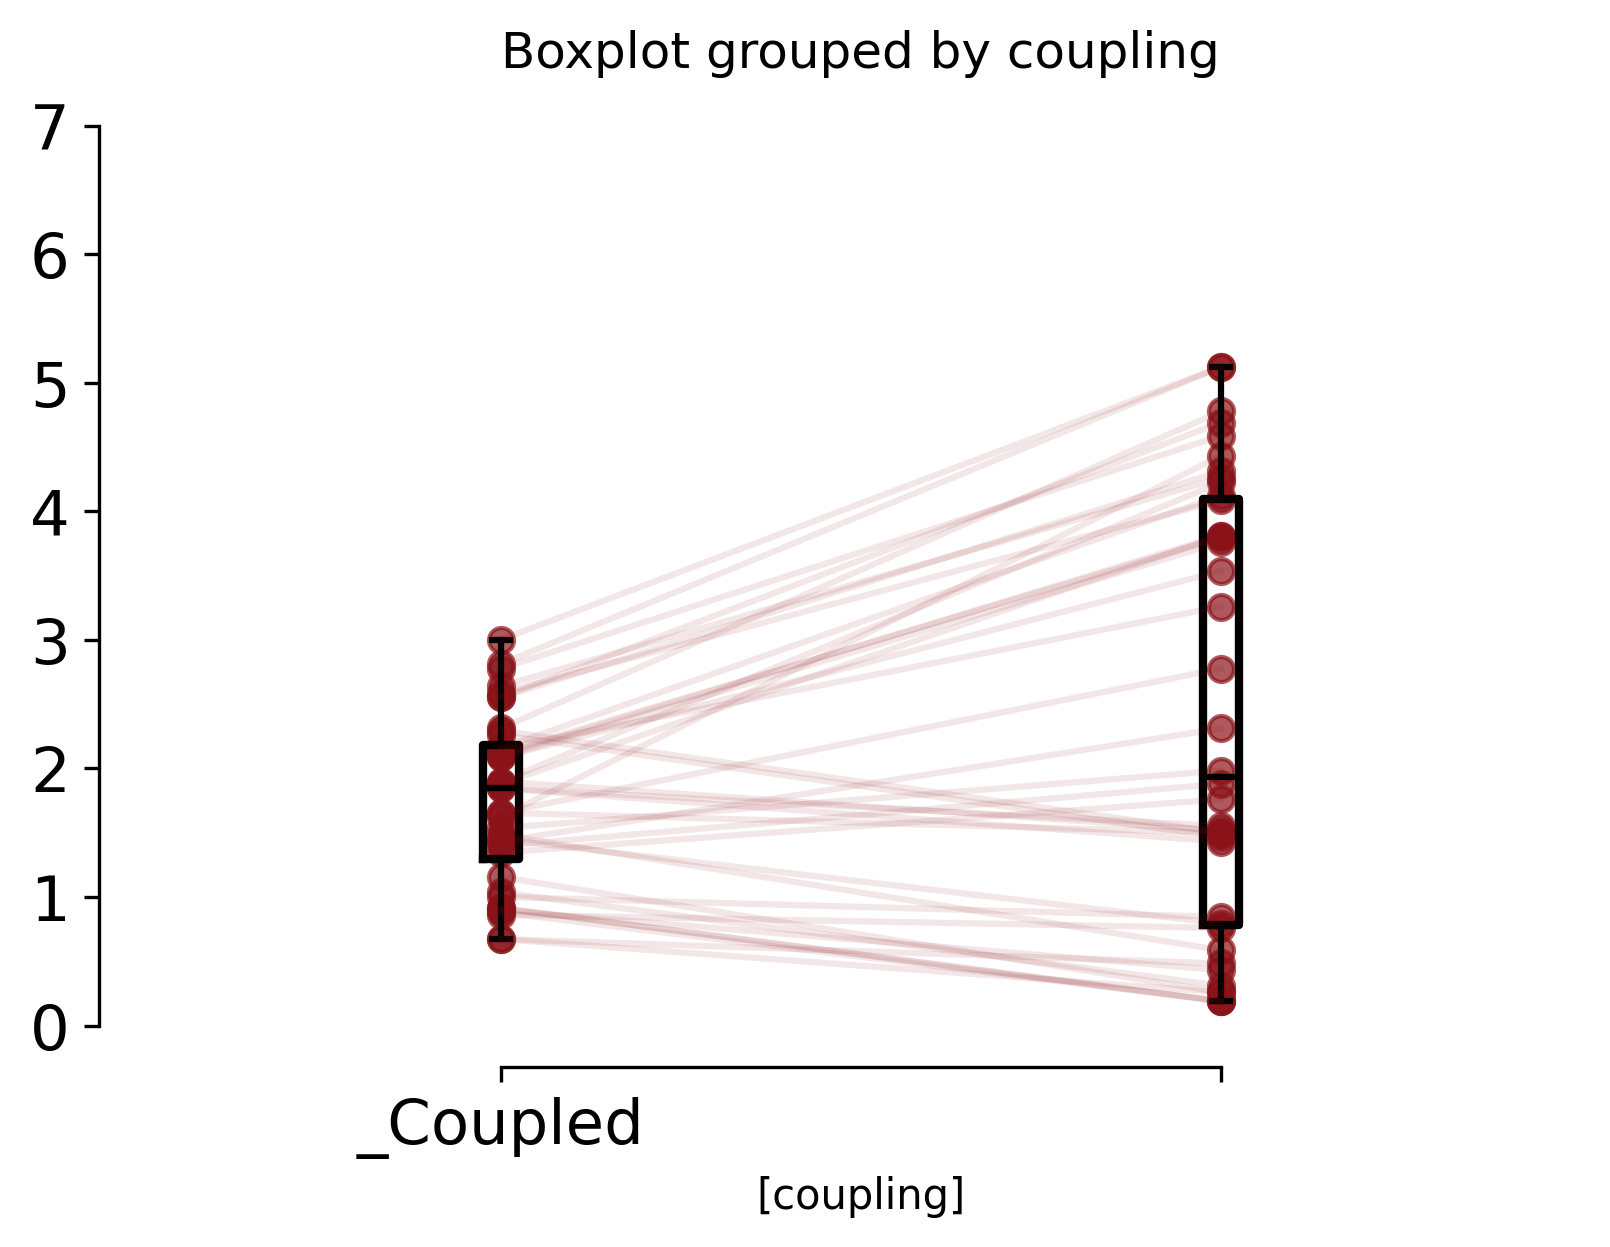

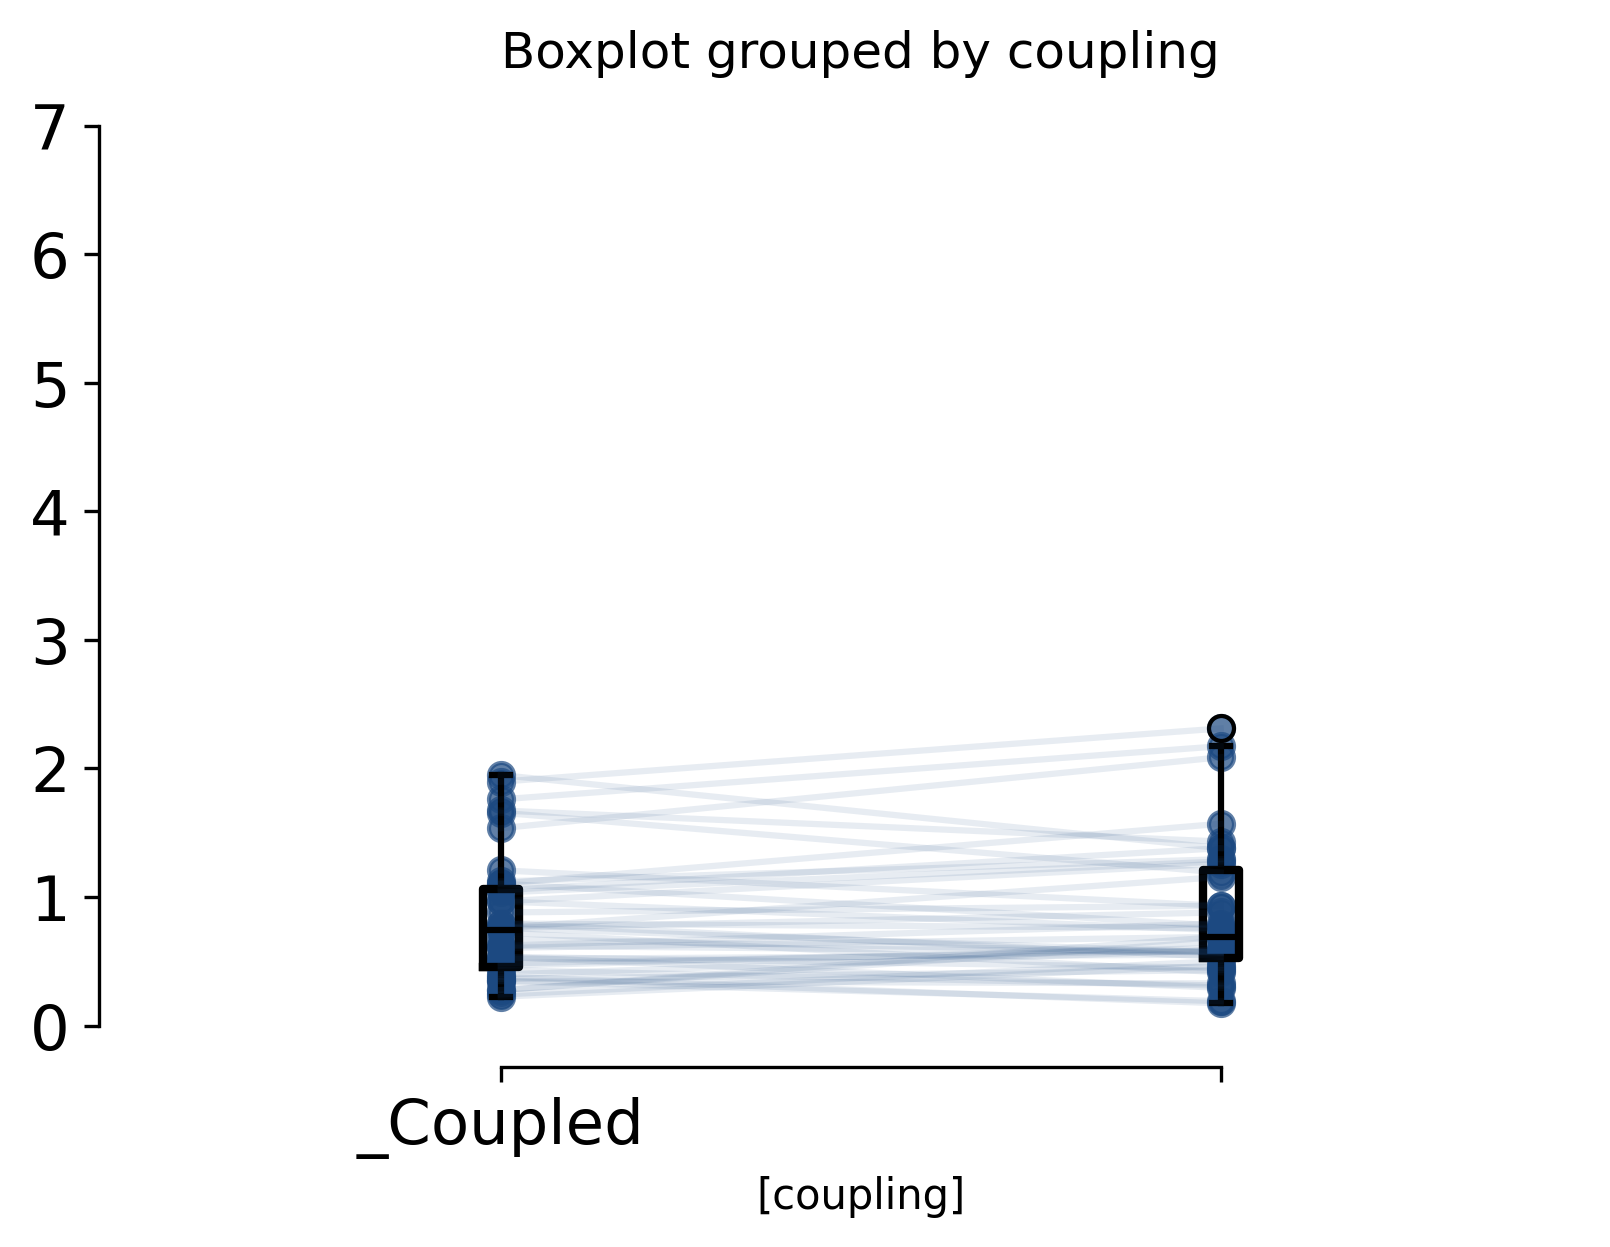

CPU times: user 2.07 s, sys: 4.34 s, total: 6.41 s
Wall time: 1.5 s


In [2]:
%%time
t_start = 1 * second
t_stop = 59 * second
bin_size = 1 * second
coupling = '_Coupled'

cell_pop_sizes = dict(PC=N_Cells_PC,IO=N_Cells_IO,DCN=N_Cells_DCN)
colors = dict(positive='#1c4981',negative='#8a1218')
names = {}
for plasticity in plasticity_range:
    if plasticity == 'no_Plasticity': names[f'{plasticity}'] = 'NP'
    elif plasticity == 'Plasticity': names[f'{plasticity}'] = 'P1'
    elif plasticity == 'Plasticity2': names[f'{plasticity}'] = 'P2'
    elif plasticity == 'Plasticity3': names[f'{plasticity}'] = 'P3'
    elif plasticity == 'Plasticity4': names[f'{plasticity}'] = 'P4'
    elif plasticity == 'after_Plasticity': names[f'{plasticity}'] = 'AP1'
    elif plasticity == 'after_Plasticity2': names[f'{plasticity}'] = 'AP2'
    elif plasticity == 'after_Plasticity3': names[f'{plasticity}'] = 'AP3'
    elif plasticity == 'after_Plasticity4': names[f'{plasticity}'] = 'AP4'
        
data = []
for coupling in (['', '_Coupled']):
    for cell_name in ['PC','IO']:
        for zebrin in zebrin_range:
            for order,plasticity in enumerate(['after_Plasticity']):
                spikes_output = output_load_run(f'{cell_name}_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                for cell_num in range(cell_pop_sizes[cell_name]):
                    spikes = spikes_output[f'{cell_num}']
                    bin_edges = np.arange(t_start, t_stop+bin_size, bin_size)
                    spike_counts, _ = np.histogram(spikes, bins=bin_edges)
                    mean_count = spike_counts / bin_size
                    row = dict(frequency = mean(mean_count/Hz))
                    row['cell'] = cell_name
                    row['plasticity'] = names[f'{plasticity}']
                    row['zebrin'] = zebrin
                    row['coupling'] = coupling
                    row['order'] = f'{order}'+names[f'{plasticity}']
                    data.append(row)
df_ff = pd.DataFrame(data)    

plasticity = 'after_Plasticity'
var = 'frequency'
x = {}
y = {}
for cell_name in ['PC','IO']:
    x[cell_name] = {}
    y[cell_name] = {}
    for zebrin in ['negative','positive']:
        df_data = df_ff[(df_ff.plasticity==names[f'{plasticity}']) & (df_ff["cell"]==cell_name) & (df_ff["zebrin"]==zebrin)]
        Q1, Q3 = percentile(df_data[var],[5,95])
        IQR = Q3 - Q1    #IQR is interquartile range. 
        lower_boundary = Q1 - 1.5 * IQR
        upper_boundary = Q3 + 1.5 * IQR
        df_data2 = df_data[(df_data[var] < upper_boundary) & (df_data[var] > lower_boundary)]
        fig = plt.figure(dpi=300)
        flierproperties = dict(markerfacecolor = 'white', markeredgecolor = 'white')
        bp = df_data2.boxplot(column=var, by=['coupling'], grid=False, figsize=(4,3), widths=0.05, fontsize=15,
                             color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                             boxprops=dict(linestyle='-', linewidth=2),
                             flierprops=dict(linestyle='-', linewidth=1.5),
                             medianprops=dict(linestyle='-', linewidth=1.5, color = 'k'),
                             whiskerprops=dict(linestyle='-', linewidth=1.5),
                             capprops=dict(linestyle='-', linewidth=1.5),
                         positions=[2,1],ax = plt.gca())      
        title(f'')#title(f'CF Pauses {plasticity}{coupling}')
#         colors = dict(positive='b',negative='r')
        x[cell_name][zebrin] = {}
        y[cell_name][zebrin] = {}
        for i,coupling in enumerate(['_Coupled', '']):
            y[cell_name][zebrin][f'{coupling}'] = df_data2.frequency[(df_data2.zebrin==zebrin) & (df_data2.coupling==coupling)].dropna()
            x[cell_name][zebrin][f'{coupling}'] = [1+i]*len(y[cell_name][zebrin][f'{coupling}'])#np.random.normal(1+j+(len(plasticity_range[0:1]))*i, 0.12, size=len(y))    # Add some random "jitter" to the x-axis
            scatter(x[cell_name][zebrin][f'{coupling}'], y[cell_name][zebrin][f'{coupling}'],color=f'{colors[zebrin]}', alpha=0.7)
        toPlot = zip(x[cell_name][zebrin]['_Coupled'], y[cell_name][zebrin]['_Coupled'], x[cell_name][zebrin][''], y[cell_name][zebrin][''])
        for tuple in toPlot:
            plot([tuple[0], tuple[2]], [tuple[1], tuple[3]], color=f'{colors[zebrin]}',alpha=0.1)
        xticks([1,2],['_Coupled', ''])
        if cell_name == 'PC':
            ylim([30,110])
        elif cell_name == 'IO':
            ylim([0,7])
        elif cell_name == 'DCN':
            ylim([15,60])
    #     yticks(np.arange(20, 80+1, 20))
    #         axis('off')
    #         plt.ylabel("FF [Hz]")
        plt.savefig(f'{cell_name}_{var}_{coupling}_boxplot_{zebrin}.svg')
        sns.despine(trim=True,offset = 10)
        plt.show()

## Statistics across coupling

In [7]:
from prettytable import PrettyTable
import numpy as np
from scipy.stats import mannwhitneyu, ttest_ind, f


# Function to format p-values
def format_p_value(p):
    return "<0.001" if p < 0.001 else round(p, 3)

# Function to create a table for a specific cell_name
def create_table(cell_name, y):
    table = PrettyTable(["Test", "Upbound", "Downbound"])
    table.align = "l"  # Left-align columns

    # Prepare placeholders for results
    results = {
        "Mann-Whitney U stat": [None, None],
        "Mann-Whitney U p": [None, None],
        "F-test stat": [None, None],
        "F-test p": [None, None],
        "t-test stat": [None, None],
        "t-test p": [None, None],
    }

    # Loop through Zebrin types
    for i, zebrin in enumerate(['positive', 'negative']):
        # Calculate Mann-Whitney U test
        U1, p_mw = mannwhitneyu(
            y[cell_name][zebrin]['_Coupled'],
            y[cell_name][zebrin][''],
            method="exact"
        )

        # Calculate F-test for variance
        variance1 = np.var(y[cell_name][zebrin]['_Coupled'], ddof=1)
        variance2 = np.var(y[cell_name][zebrin][''], ddof=1)
        f_value = variance1 / variance2
        df1 = len(y[cell_name][zebrin]['_Coupled']) - 1
        df2 = len(y[cell_name][zebrin]['']) - 1
        p_f = f.sf(f_value, df1, df2)

        # Calculate t-test for means
        t_stat, p_t = ttest_ind(
            y[cell_name][zebrin]['_Coupled'],
            y[cell_name][zebrin]['']
        )

        # Save results in the correct column
        results["Mann-Whitney U stat"][i] = round(U1, 2)
        results["Mann-Whitney U p"][i] = format_p_value(p_mw)
        results["F-test stat"][i] = round(f_value, 2)
        results["F-test p"][i] = format_p_value(p_f)
        results["t-test stat"][i] = round(t_stat, 2)
        results["t-test p"][i] = format_p_value(p_t)

    # Add results to the table
    for test_name, values in results.items():
        table.add_row([test_name] + values)

    return table

# Create and print tables for each cell_name
for cell_name in ['PC', 'IO']:
    print(f"Coupling Comparison Results for {cell_name}:")
    print(create_table(cell_name, y))
    print("\n")

Coupling Comparison Results for PC:
+---------------------+---------+-----------+
| Test                | Upbound | Downbound |
+---------------------+---------+-----------+
| Mann-Whitney U stat | 5236.0  | 4442.5    |
| Mann-Whitney U p    | 0.566   | 0.174     |
| F-test stat         | 0.14    | 0.42      |
| F-test p            | 1.0     | 1.0       |
| t-test stat         | 0.74    | -1.55     |
| t-test p            | 0.462   | 0.123     |
+---------------------+---------+-----------+


Coupling Comparison Results for IO:
+---------------------+---------+-----------+
| Test                | Upbound | Downbound |
+---------------------+---------+-----------+
| Mann-Whitney U stat | 770.5   | 692.0     |
| Mann-Whitney U p    | 0.785   | 0.303     |
| F-test stat         | 0.82    | 0.14      |
| F-test p            | 0.732   | 1.0       |
| t-test stat         | -0.37   | -2.28     |
| t-test p            | 0.715   | 0.026     |
+---------------------+---------+-----------+




## Statistics across zones

In [5]:
from prettytable import PrettyTable
import numpy as np
from scipy.stats import mannwhitneyu, ttest_ind, f

# Function to format p-values
def format_p_value(p):
    return "<0.001" if p < 0.001 else round(p, 3)

# Function to create a table for zebrin comparison
def create_zebrin_comparison_table(cell_name, y):
    table = PrettyTable(["Test", "Coupled", "Uncoupled"])  # Columns for no_coupling (NP) and after_coupling (AP)
    table.align = "l"  # Left-align columns

    # Prepare placeholders for results
    results = {
        "Mann-Whitney U stat": [None, None],
        "Mann-Whitney U p": [None, None],
        "F-test stat": [None, None],
        "F-test p": [None, None],
        "t-test stat": [None, None],
        "t-test p": [None, None],
    }

    # Loop through coupling conditions
    for i, coupling in enumerate(['_Coupled', '']):
        # Calculate Mann-Whitney U test
        U1, p_mw = mannwhitneyu(
            y[cell_name]['negative'][coupling],
            y[cell_name]['positive'][coupling],
            method="exact"
        )

        # Calculate F-test for variance
        variance1 = np.var(y[cell_name]['negative'][coupling], ddof=1)
        variance2 = np.var(y[cell_name]['positive'][coupling], ddof=1)
        f_value = variance1 / variance2
        df1 = len(y[cell_name]['negative'][coupling]) - 1
        df2 = len(y[cell_name]['positive'][coupling]) - 1
        p_f = f.sf(f_value, df1, df2)

        # Calculate t-test for means
        t_stat, p_t = ttest_ind(
            y[cell_name]['negative'][coupling],
            y[cell_name]['positive'][coupling]
        )

        # Save results in the correct column
        results["Mann-Whitney U stat"][i] = round(U1, 2)
        results["Mann-Whitney U p"][i] = format_p_value(p_mw)
        results["F-test stat"][i] = round(f_value, 2)
        results["F-test p"][i] = format_p_value(p_f)
        results["t-test stat"][i] = round(t_stat, 2)
        results["t-test p"][i] = format_p_value(p_t)

    # Add results to the table
    for test_name, values in results.items():
        table.add_row([test_name] + values)

    return table


# Create and print tables for each cell_name
for cell_name in ['PC', 'IO']:
    print(f"Zebrin Comparison Results for {cell_name}:")
    print(create_zebrin_comparison_table(cell_name, y))
    print("\n")

Zebrin Comparison Results for PC:
+---------------------+---------+-----------+
| Test                | Coupled | Uncoupled |
+---------------------+---------+-----------+
| Mann-Whitney U stat | 1967.5  | 3822.5    |
| Mann-Whitney U p    | <0.001  | 0.004     |
| F-test stat         | 5.87    | 1.94      |
| F-test p            | <0.001  | <0.001    |
| t-test stat         | -8.72   | -3.02     |
| t-test p            | <0.001  | 0.003     |
+---------------------+---------+-----------+


Zebrin Comparison Results for IO:
+---------------------+---------+-----------+
| Test                | Coupled | Uncoupled |
+---------------------+---------+-----------+
| Mann-Whitney U stat | 1396.5  | 1201.5    |
| Mann-Whitney U p    | <0.001  | <0.001    |
| F-test stat         | 1.83    | 10.4      |
| F-test p            | 0.031   | <0.001    |
| t-test stat         | 7.39    | 5.51      |
| t-test p            | <0.001  | <0.001    |
+---------------------+---------+-----------+


